In [382]:
from pydub import AudioSegment
import scipy
import random

def label_out(inp):
    temp=''
    for c in inp:
        if(c=='/'):
            break
        else:
            temp=temp+c
    temp = word_dict[temp]
    return temp

In [434]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = []
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            a = graph_spectrogram('aud_data/' +  ID )
            b = np.zeros((101,198))
            if (np.shape(a)!=(101,198)):
                b[:,:a.shape[1]] +=a
                c = b
            else:
                c = a
                
            d, ll = self.__string_from_words(list_IDs_temp,ID)
            e = graph_spectrogram(d)
            f = np.zeros((101,398))
            if (np.shape(e)!=(101,398)):
                f[:,:e.shape[1]] +=e
                X[i,] = f
            else:
                X[i,] = e
            
#             Store class
#             temp = label_out(ID)
#             print(temp)
            y.append(ll)
#             y[i] = labels[i]  
        return X, y

    def __string_from_words(self, list_IDs_temp, ID):
        
        sound1 = AudioSegment.from_wav('aud_data/' +  ID )
        id1 = label_out(ID)
        temp_audio = random.choice(list_IDs_temp)
        if(temp_audio != ID):
            id2 = label_out(temp_audio)
            sound2 = AudioSegment.from_wav('aud_data/' + temp_audio)
        combined_sounds = sound1+sound2
        list_lab = []
        list_lab.append(id1)
        list_lab.append(id2)
        combined_sounds.export('dump.wav', format="wav")
        return "dump.wav", list_lab
        os.remove('dump.wav')
            
        

In [405]:
from keras.models import Sequential

import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [406]:
path = '/home/isro/conversational_bot'
print(path)
os.chdir(path)
os.getcwd()
os.listdir()

/home/isro/conversational_bot


['.git',
 'coursera',
 'dump.wav',
 'Untitled.ipynb',
 'data_aug_func.ipynb',
 'aud_data',
 'validation_list.txt',
 'testing_list.txt',
 'meta (2).tsv',
 'aimlbot',
 'vecs (2).tsv',
 'speech_recog_ctc.ipynb',
 'word_embeddings.ipynb',
 'Word_embeddings',
 '_background_noise_',
 'data_gen_aud_aug.ipynb',
 'mod_aud.flac',
 '.ipynb_checkpoints',
 'LICENSE',
 'README.md']

In [407]:
file = open("testing_list.txt")
# print(file.read())

In [408]:
train_list = []
valid_list = []
def listing(file, l):
    crimefile = open(file, 'r')
    for line in crimefile.readlines():
    #     row.append([line])
        for i in line.split("\n"):
            l.append(i)
    for e in l:
        if (e == ''):
            l.remove(e)

listing("testing_list.txt",train_list)
listing("validation_list.txt", valid_list)

In [409]:
print(train_list[4])

bed/1528225c_nohash_0.wav


In [435]:
labels= []
labels_valid=[]

word_dict = {"bed": 0, "bird":1, "cat":2, "dog":3, "down":4, "eight":5, "five":6,
             "four":7, "go":8,"happy":9,"house":10,"left":11,
             "marvin":12,"nine":13,"no":14,"off":15,"one":16,"on":17,"two":18,
             "right":19,"seven":20,"sheila":21,"stop":22,"three":23,"tree":24,
             "up":25,"wow":26,"yes":27,"zero":28, "six": 29}

def make_labels(ls,file):
    for i in file:
        temp=''
        for c in i:
            if(c=='/'):
                break
            else:
                temp=temp+c
#         ls.append(temp)
        ls.append(word_dict[temp])
#     print(temp)
# print(labels[4])
make_labels(labels, train_list)
make_labels(labels_valid, valid_list)

# print(labels)
    

In [436]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    noise_inj(wav_file, 0.1)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate , data = wavfile.read(wav_file)
    return rate, data

def noise_inj(audio, noise_factor):      #introducing random noise in the audio file
    sr,data = get_wav_info(audio)
    noise = np.random.randn(len(data)) 
    aug_data=data + noise_factor * noise 
    aug_data = aug_data.astype(type(data[0])) 
#     sf.write("mod_aud.flac", aug_data, sr)
    return aug_data
 

In [437]:
from keras.models import Sequential
# import DataGenerator

# Parameters
params = {'dim': (101,398),
          'batch_size': 32,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}


# Generators
training_generator = DataGenerator(train_list, labels, **params)

UnboundLocalError: local variable 'sound2' referenced before assignment

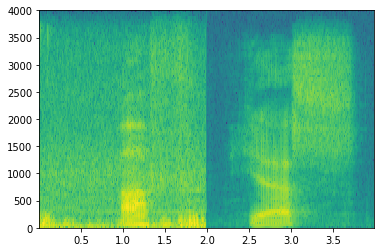

In [438]:
x, y = training_generator.__getitem__(4)
print(y[4])
print(x[4])

In [423]:
print(x.shape)
print(np.shape(y))

(32, 101, 198)
(32,)
